Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817 ] max: [1.49563575 1.70671805 1.41547433 1.37969415]
Created cyclic encodings for time features
Using device: cuda
Categorical vocabulary sizes: {'merchant': 693, 'category': 14, 'gender': 2, 'street': 999, 'city': 906, 'state': 51, 'zip': 985, 'job': 497}
Starting training …


d:\ProgramData\anaconda3\envs\Env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/550], Loss: 6.1293
Epoch [10/550], Loss: 2.2534
Epoch [20/550], Loss: 2.0193
Epoch [30/550], Loss: 1.2753
Epoch [40/550], Loss: 1.2060
Epoch [50/550], Loss: 0.9487
Epoch [60/550], Loss: 0.8580
Epoch [70/550], Loss: 0.8815
Epoch [80/550], Loss: 0.8306
Epoch [90/550], Loss: 0.5987
Epoch [100/550], Loss: 0.5904
Epoch [110/550], Loss: 0.5747
Epoch [120/550], Loss: 0.5904
Epoch [130/550], Loss: 0.5501
Epoch [140/550], Loss: 0.5832
Epoch [150/550], Loss: 0.5990
Epoch [160/550], Loss: 0.5330
Epoch [170/550], Loss: 0.5176
Epoch [180/550], Loss: 0.4866
Epoch [190/550], Loss: 0.4198
Epoch [200/550], Loss: 0.4339
Epoch [210/550], Loss: 0.4211
Epoch [220/550], Loss: 0.4040
Epoch [230/550], Loss: 0.3869
Epoch [240/550], Loss: 0.3818
Epoch [250/550], Loss: 0.3627
Epoch [260/550], Loss: 0.3511
Epoch [270/550], Loss: 0.3472
Epoch [280/550], Loss: 0.3754
Epoch [290/550], Loss: 0.3769
Epoch [300/550], Loss: 0.3547
Epoch [310/550], Loss: 0.3573
Epoch [320/550], Loss: 0.3440
Epoch [330/550], Loss

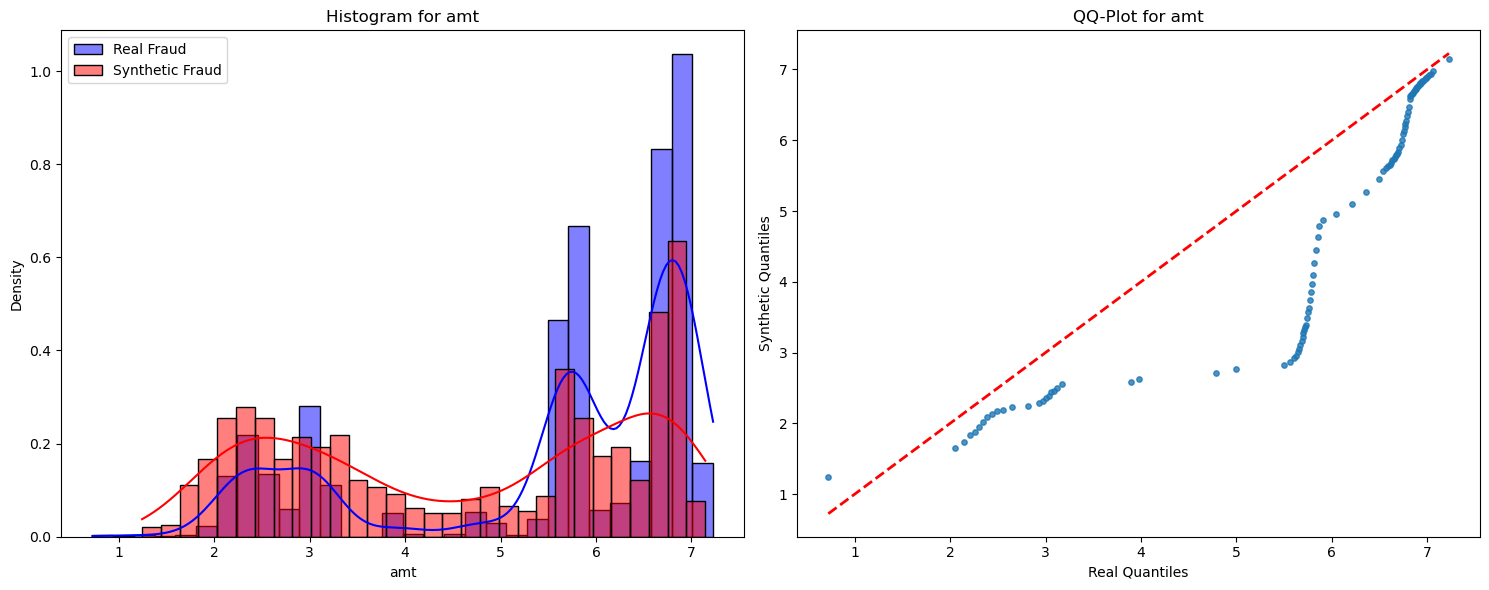

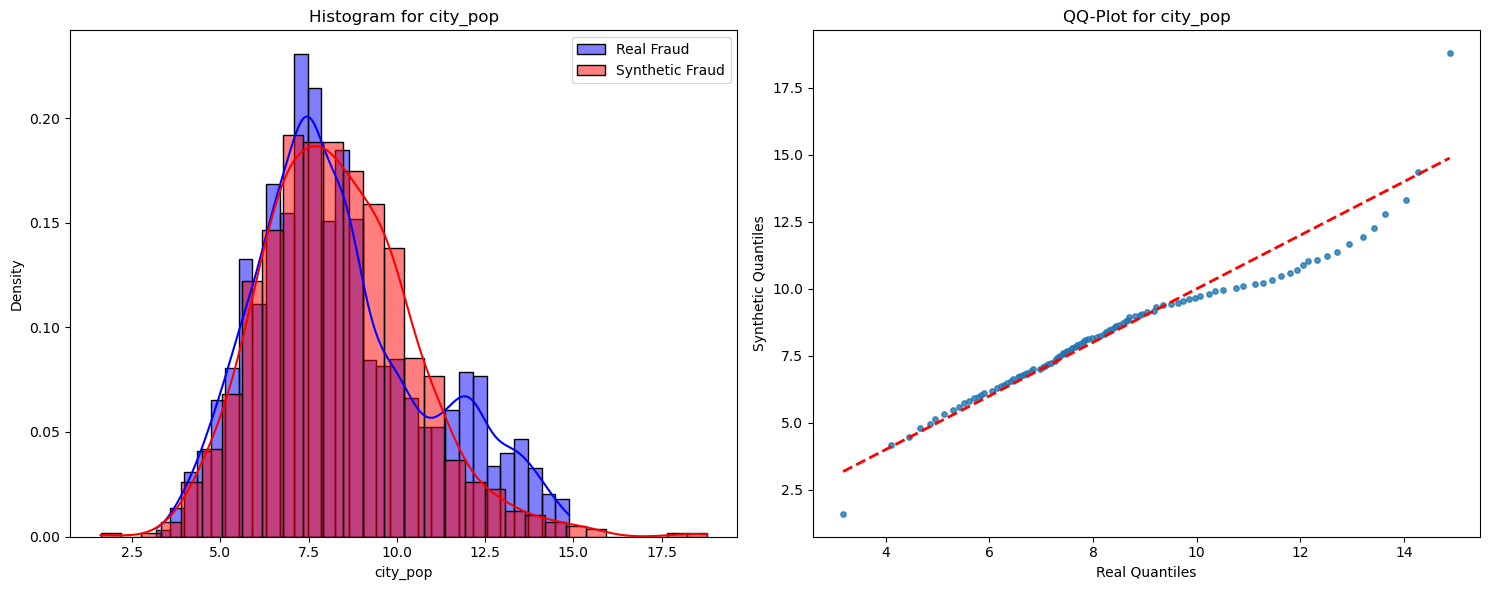

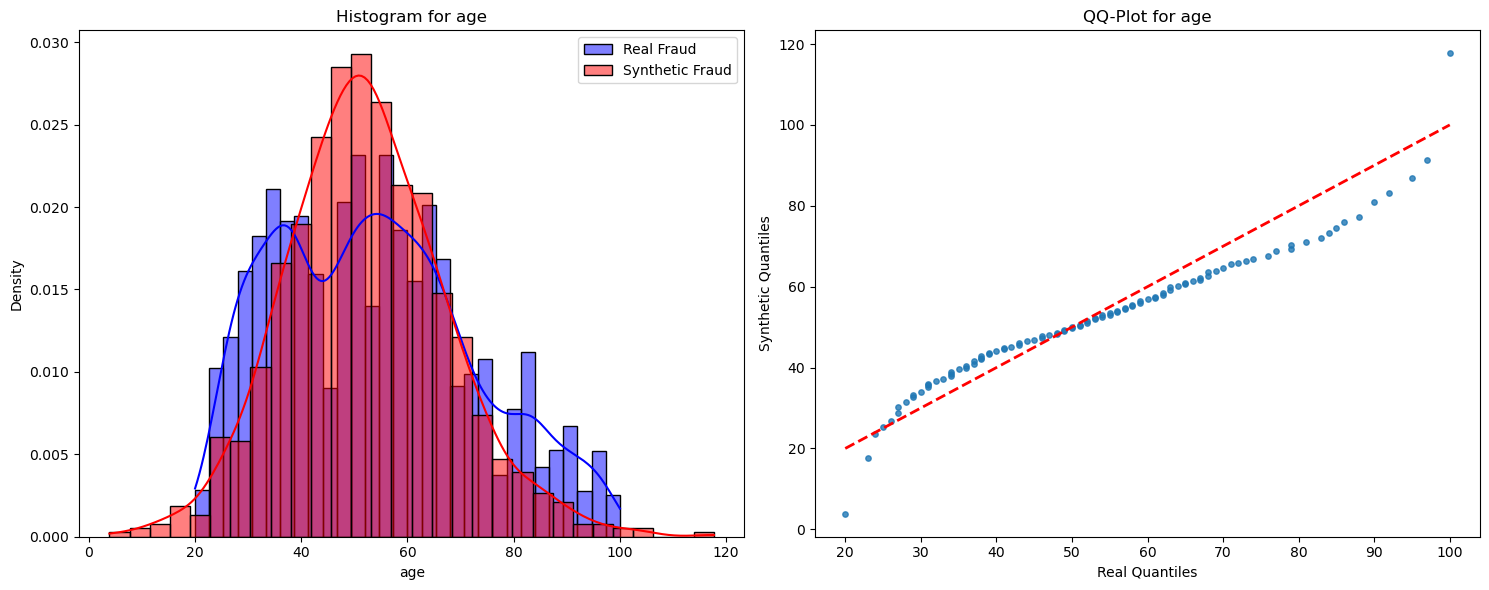

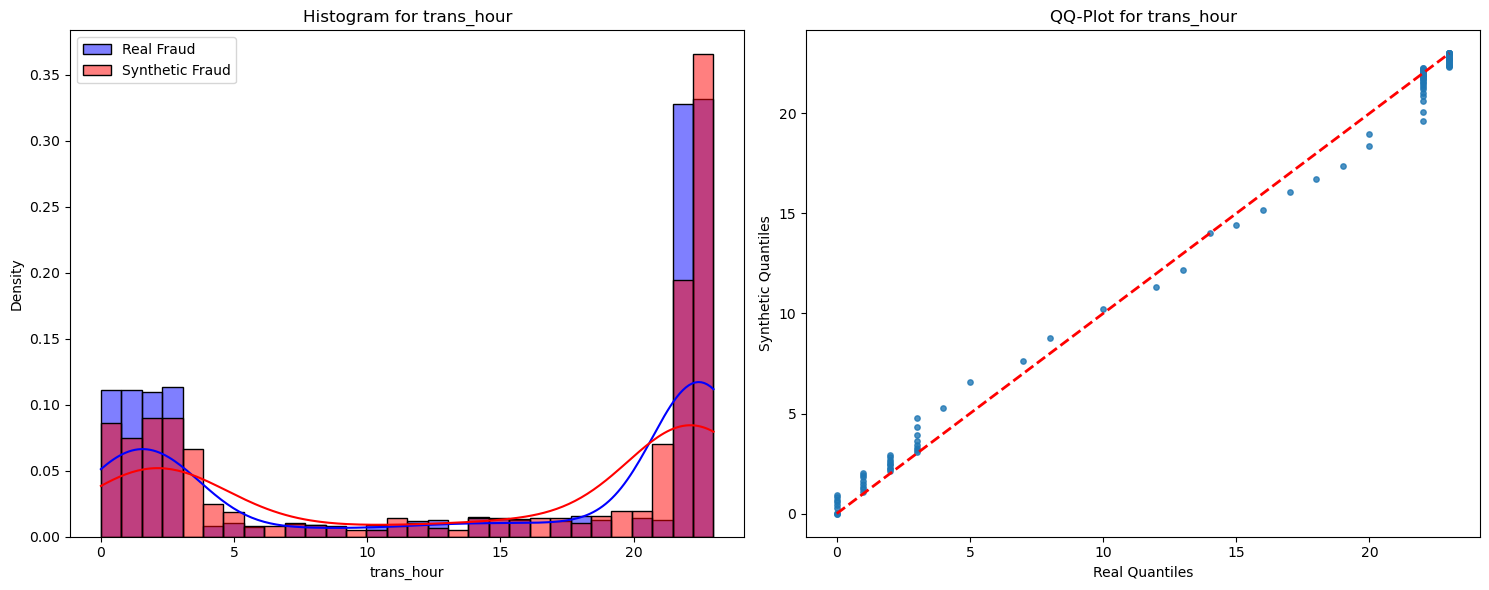

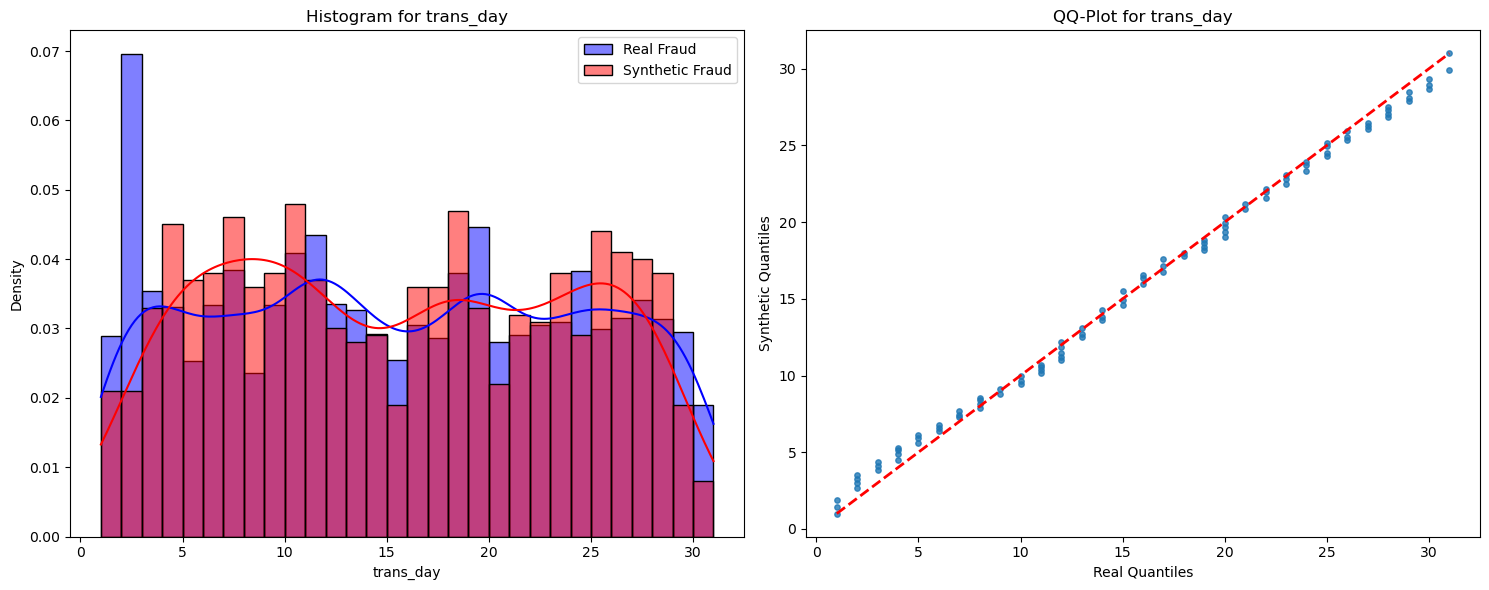

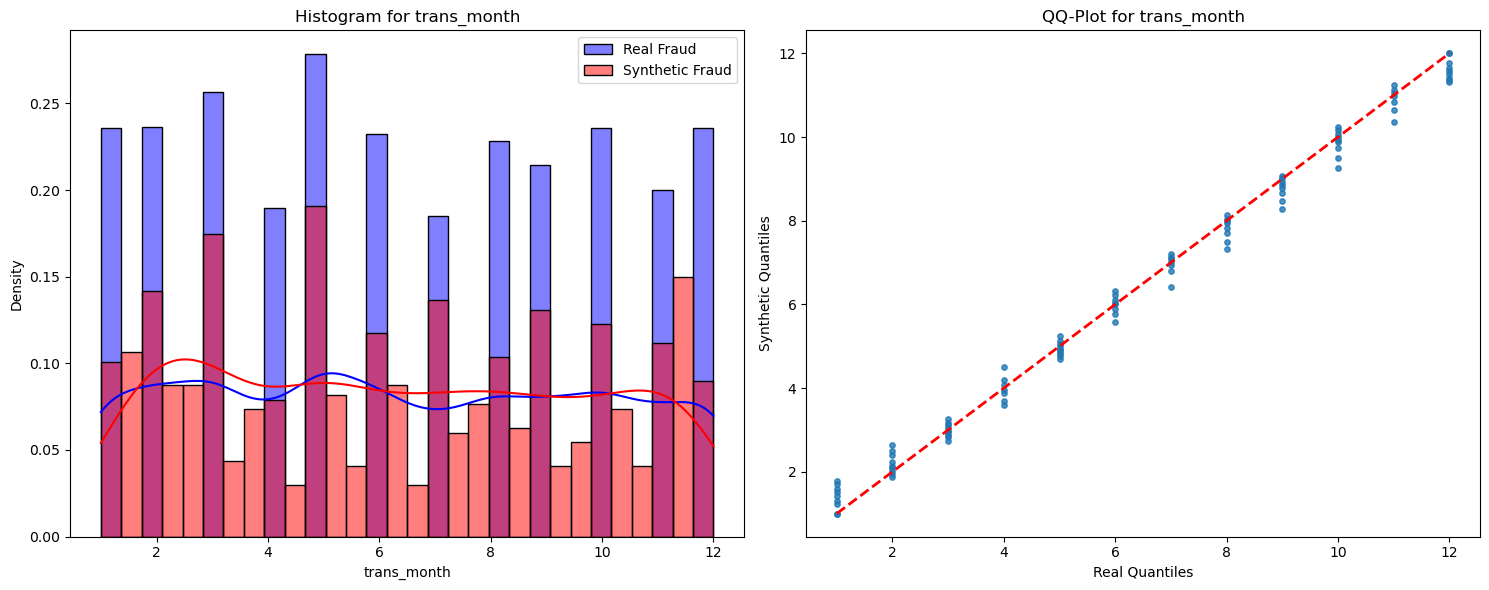

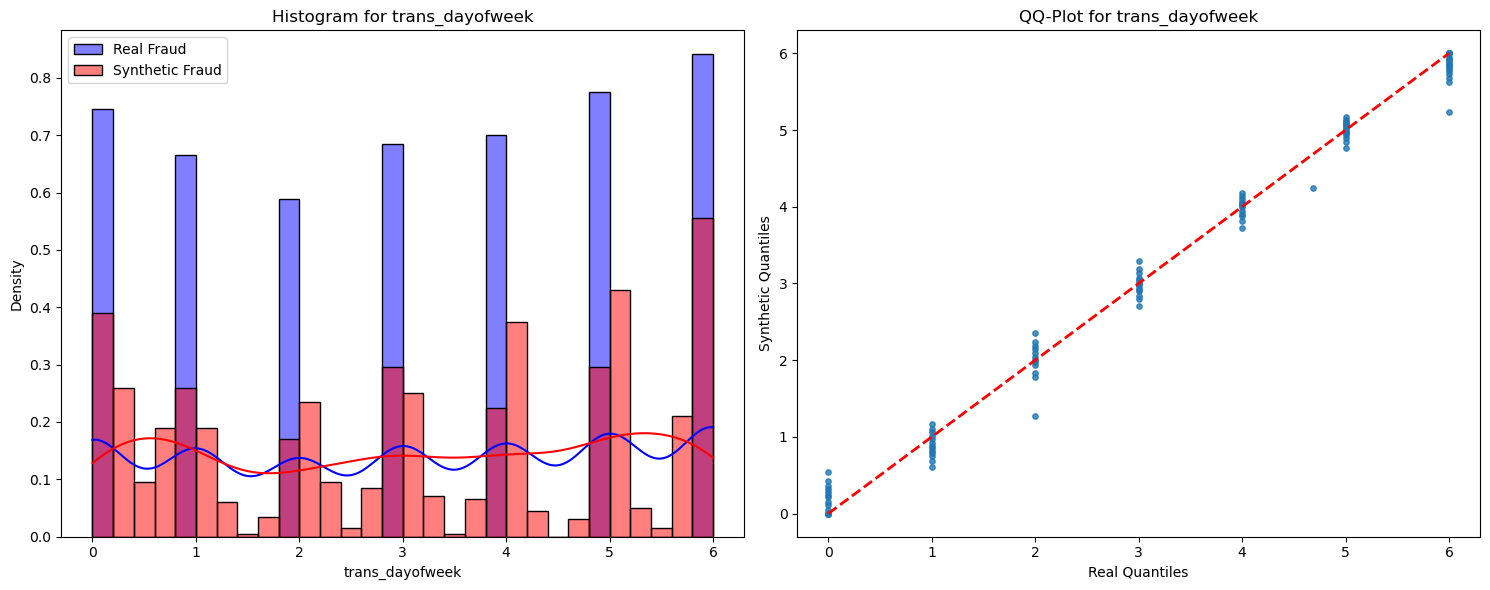

Synthetic data saved to CSV


In [2]:
"""
Improved FraudDiffuse Model – Version 3
Building on v2 with additional improvements:
  • Feature-specific initialization for amt
  • Cyclical encoding for time features (hour, day, month, dayofweek)
  • More targeted loss weighting based on v2 results
  • Learning rate scheduler for better convergence
  • Increased model capacity
"""

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

#############################################
# Step 1: Load Preprocessed Data & Artifacts
#############################################
# Use raw strings to avoid escape-sequence issues.
X_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\X_train.csv")
y_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\y_train.csv")

scaler = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\standard_scaler.pkl")
cat_vocab = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_vocab.pkl")
cat_mapping = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_mapping.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# Define feature lists exactly as used during preprocessing.
# All numeric features were standard-scaled.
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Categorical features (factorized)
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Get target values (assume first column in y_train_df is target).
y_train = y_train_df.iloc[:, 0]

# Create masks.
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Filter training data.
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values   # Standard-scaled numeric features.
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values         # Integer codes.

X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

#############################################
# Step 1b: Compute observed range for engineered features
#############################################
# Engineered features are those extracted from datetime:
eng_features = ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Find their indices in "numeric_features"
eng_indices = [numeric_features.index(feat) for feat in eng_features]

# Also get the index for amt
amt_idx = numeric_features.index('amt')

# Compute column-wise min and max for engineered features from the fraud training set
# (They are in standardized space.)
eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
# Convert to torch tensors
eng_min = torch.tensor(eng_min_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
eng_max = torch.tensor(eng_max_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

# CHANGE: Create cyclic encodings for time features
def create_cyclic_features(data, feature_indices, periods):
    """Create sine and cosine features for cyclical data"""
    cyclic_data = np.zeros((data.shape[0], len(feature_indices) * 2))
    
    for i, (idx, period) in enumerate(zip(feature_indices, periods)):
        # Normalize to [0, 2π]
        values = data[:, idx].copy()
        normalized = 2 * np.pi * values / period
        
        # Create sin and cos features
        cyclic_data[:, i*2] = np.sin(normalized)
        cyclic_data[:, i*2+1] = np.cos(normalized)
        
    return cyclic_data

# Define periods for each time feature (after inverse transform)
# Note: We estimate the periods based on the feature names
hour_period = 24.0  # 24 hours in a day
day_period = 31.0   # Max days in a month
month_period = 12.0 # 12 months in a year
dow_period = 7.0    # 7 days in a week

periods = [hour_period, day_period, month_period, dow_period]

# Inverse transform the data to get the original scale
X_train_num_original = scaler.inverse_transform(X_train_num)
X_nonfraud_num_original = scaler.inverse_transform(X_nonfraud_num)

# Create cyclic features using original scale data
cyclic_fraud = create_cyclic_features(
    X_train_num_original, 
    [numeric_features.index(feat) for feat in eng_features], 
    periods
)

cyclic_nonfraud = create_cyclic_features(
    X_nonfraud_num_original,
    [numeric_features.index(feat) for feat in eng_features],
    periods
)

print("Created cyclic encodings for time features")

#############################################
# Step 2: Create a Custom Dataset for Fraud Samples
#############################################
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data, cyclic_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
        self.cyclic_data = torch.tensor(cyclic_data, dtype=torch.float32)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx], self.cyclic_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat, cyclic_fraud)

#############################################
# Step 3: Set Device and Diffusion Hyperparameters
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

# CHANGE: Adjusted weights based on v2 results
w1 = 0.2  # Prior weight
w2 = 0.6  # Triplet loss weight
lambda_eng = 0.15   # Weight for engineered range loss (increased)
lambda_amt = 0.1    # New weight for amount-specific loss

#############################################
# Step 4: Define the Diffusion Model
#############################################
class CombinedNoisePredictor(nn.Module):
    """
    Enhanced version that handles cyclic time encodings
    """
    def __init__(self, num_input_dim, cat_vocab_sizes, cyclic_dim=8, cat_embed_dim=4, hidden_dim=320):
        super(CombinedNoisePredictor, self).__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        
        # CHANGE: Now includes cyclic dimensions in the input
        combined_input_dim = num_input_dim + cat_total_dim + cyclic_dim
        
        # CHANGE: Deeper network with residual connections
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, combined_input_dim)
        
        # Separate projections for skip connections
        self.skip_proj = nn.Linear(combined_input_dim + 1, hidden_dim)
        
        self.activation = nn.SiLU()  # Changed to SiLU (Swish) for better performance
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x_num, x_cat, x_cyclic, t):
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        
        # Include cyclic features in the concatenation
        x = torch.cat([x_num, x_cat_emb, x_cyclic], dim=1)
        
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        
        # Residual connections
        skip = self.skip_proj(x_input)
        
        h = self.activation(self.fc1(x_input))
        h = self.dropout(h)
        h = self.activation(self.fc2(h)) + skip
        h = self.dropout(h)
        h = self.activation(self.fc3(h)) + h
        out = self.fc4(h)
        
        return out

cat_vocab_sizes = {col: cat_vocab[col] for col in cat_features}
print("Categorical vocabulary sizes:", cat_vocab_sizes)

num_input_dim = len(numeric_features)
cyclic_dim = len(eng_features) * 2  # sin & cos for each time feature

model = CombinedNoisePredictor(
    num_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    cyclic_dim=cyclic_dim,
    cat_embed_dim=4,  # Increased from 2
    hidden_dim=320    # Increased from 256
).to(device)

#############################################
# Step 5: Define Loss Functions, Forward Diffusion, and Feature-Specific Losses
#############################################
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
X_cyclic_nonfraud_tensor = torch.tensor(cyclic_nonfraud, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_feature_weighted_Lnorm(pred_noise, true_noise):
    # CHANGE: Refined feature weights based on v2 results
    feature_weights = torch.ones(num_input_dim, device=device)
    
    # Indices in numeric_features for challenging features
    amt_idx = numeric_features.index('amt')
    hour_idx = numeric_features.index('trans_hour')
    month_idx = numeric_features.index('trans_month')
    dow_idx = numeric_features.index('trans_dayofweek')
    day_idx = numeric_features.index('trans_day')
    
    # Apply weights based on v2 performance
    feature_weights[amt_idx] = 2.5      # Increased weight for amount
    feature_weights[hour_idx] = 2.0     # Increased for trans_hour 
    feature_weights[month_idx] = 1.5    # Slightly increased
    feature_weights[dow_idx] = 1.5      # Slightly increased
    feature_weights[day_idx] = 1.0      # Keeping neutral weight for trans_day
    
    # Weighted MSE
    squared_diff = (pred_noise - true_noise)**2
    weighted_squared_diff = squared_diff * feature_weights.unsqueeze(0)
    return weighted_squared_diff.mean()

def compute_Lprior(pred_noise):
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0,1)
    prob = 1 - normal.cdf(z_abs)
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    # Penalize values below eng_min or above eng_max.
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

# CHANGE: New loss component to enforce proper amt distribution
def amount_distribution_loss(x0_est_amt, real_amt):
    """Specialized loss for amount distribution, enforcing skewness"""
    # Calculate batch statistics
    batch_mean = x0_est_amt.mean()
    batch_std = x0_est_amt.std() + 1e-6
    
    # Get real data statistics
    real_mean = real_amt.mean()
    real_std = real_amt.std() + 1e-6
    
    # Compute skewness (third moment)
    est_skewness = torch.mean(((x0_est_amt - batch_mean) / batch_std) ** 3)
    real_skewness = torch.mean(((real_amt - real_mean) / real_std) ** 3)
    
    # Penalize difference in skewness
    skew_loss = F.mse_loss(est_skewness, real_skewness)
    
    # Also add histogram matching loss (simple version)
    # Sort both tensors and compute MSE between sorted values
    x0_est_sorted, _ = torch.sort(x0_est_amt, dim=0)
    real_sorted, _ = torch.sort(real_amt, dim=0)
    
    # If the sizes don't match, we subsample the larger one
    if x0_est_sorted.size(0) > real_sorted.size(0):
        # Subsample the synthetic data
        indices = torch.linspace(0, x0_est_sorted.size(0)-1, real_sorted.size(0)).long()
        x0_est_sorted = x0_est_sorted[indices]
    elif real_sorted.size(0) > x0_est_sorted.size(0):
        # Subsample the real data
        indices = torch.linspace(0, real_sorted.size(0)-1, x0_est_sorted.size(0)).long()
        real_sorted = real_sorted[indices]
    
    # Compute histogram matching loss
    hist_loss = F.mse_loss(x0_est_sorted, real_sorted)
    
    return skew_loss + hist_loss

#############################################
# Step 6: Train the Diffusion Model (Fraud Samples Only)
#############################################
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)
num_epochs = 550  # Increased epochs
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CHANGE: Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15, verbose=True
)

# Convert real amount data to tensor for use in amount_distribution_loss
X_real_amt = torch.tensor(X_train_num[:, amt_idx], dtype=torch.float32).to(device)

print("Starting training …")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0_num, x0_cat, x0_cyclic = batch
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        x0_cyclic = x0_cyclic.to(device)
        batch_size = x0_num.shape[0]
        
        t = torch.randint(0, T_train, (batch_size,), device=device)
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        pred_noise = model(x_t_num, x0_cat, x0_cyclic, t)
        
        # Extract predicted noise for numeric features (first num_input_dim columns)
        pred_noise_numeric = pred_noise[:, :num_input_dim]
        
        L_norm = compute_feature_weighted_Lnorm(pred_noise_numeric, true_noise)
        L_prior = compute_Lprior(pred_noise_numeric)
        
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        # One-step reverse update: estimated denoised x0.
        x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / sqrt_alpha_hat_t
        
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
        
        # Compute engineered range loss on engineered feature indices.
        x0_est_eng = x0_est[:, eng_indices]
        L_eng = engineered_range_loss(x0_est_eng, eng_min, eng_max)
        
        # Compute amount-specific loss
        x0_est_amt = x0_est[:, amt_idx]
        L_amt = amount_distribution_loss(x0_est_amt, X_real_amt[:batch_size])
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + lambda_eng * L_eng + lambda_amt * L_amt
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(loader)
    # Update learning rate based on loss
    scheduler.step(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete. Saving model as 'baseline_improved_v3_MEs.pth' …")
torch.save(model.state_dict(), r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\baseline_improved_v3_MEs.pth")
print("Model saved.")

#############################################
# Step 7: Generate Synthetic Fraud Samples via Reverse Diffusion
#############################################
def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    model.eval()
    with torch.no_grad():
        # Create categorical samples
        cat_samples = {}
        for col in cat_vocab_sizes:
            vocab_size = cat_vocab_sizes[col]
            cat_samples[col] = torch.randint(0, vocab_size, (num_samples,), device=device, dtype=torch.long)
        x_cat = torch.stack([cat_samples[col] for col in cat_features], dim=1)
        
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        
        # CHANGE: Use real samples as initialization base
        idx = torch.randint(0, X_fraud_tensor.shape[0], (num_samples,), device=device)
        noise = torch.randn(num_samples, num_input_dim).to(device) * 0.7  # Reduced noise scale
        x_t_num = X_fraud_tensor[idx] + X_fraud_tensor.std(dim=0, keepdim=True) * noise
        
        # Create cyclic features for generation
        X_cyclic_fraud_tensor = torch.tensor(cyclic_fraud, dtype=torch.float32).to(device)
        x_cyclic = X_cyclic_fraud_tensor[idx]
        
        # CHANGE: Special handling for amt to match the distribution better
        # For amount, initialize with a more targeted approach
        amt_idx = numeric_features.index('amt')
        
        # Sort the fraud amounts to get distribution quantiles
        sorted_amts, _ = torch.sort(X_fraud_tensor[:, amt_idx])
        
        # Generate from quantiles for better distribution matching
        quantile_indices = torch.rand(num_samples, device=device) * (sorted_amts.size(0) - 1)
        quantile_indices = quantile_indices.long()
        
        # Replace the amount feature with quantile-based values (slight noise added)
        x_t_num[:, amt_idx] = sorted_amts[quantile_indices] + torch.randn(num_samples, device=device) * 0.5
        
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            
            pred_noise = model(x_t_num, x_cat, x_cyclic, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            
            # Add less noise in later steps
            noise_scale = torch.sqrt(beta_t)
            if t_step < 200:  # Reduce noise in later steps
                noise_scale = noise_scale * (t_step / 200.0)
                
            z = torch.randn_like(x_t_num) * noise_scale if t_step > 1 else torch.zeros_like(x_t_num)
            
            x_t_num = (x_t_num - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise_numeric) / sqrt_alpha_t + z
        
        # After reverse diffusion, clip engineered features to observed range.
        x_t_num_clipped = x_t_num.clone()
        x0_est_eng = x_t_num[:, eng_indices]
        x0_est_eng = torch.max(torch.min(x0_est_eng, eng_max.unsqueeze(0)), eng_min.unsqueeze(0))
        x_t_num_clipped[:, eng_indices] = x0_est_eng
        
        return x_t_num_clipped, x_cat

# Generate more synthetic samples
num_synthetic = 1000  # Increased from 100
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

#############################################
# Step 8: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

#############################################
# Step 9: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

# CHANGE: Create better visualizations including QQ plots
for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plt.figure(figsize=(15, 6))
    
    # Histogram comparison
    plt.subplot(1, 2, 1)
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    
    # QQ plot
    plt.subplot(1, 2, 2)
    from scipy import stats
    
    # Get real and synthetic data for this feature
    real_data = real_numeric_df[col].values
    syn_data = synthetic_numeric_df[col].values
    
    # Compute the quantiles using scipy
    quantiles_real = np.percentile(real_data, np.linspace(0, 100, 100))
    quantiles_syn = np.percentile(syn_data, np.linspace(0, 100, 100))
    
    # Plot the QQ plot
    plt.scatter(quantiles_real, quantiles_syn, alpha=0.8, s=15)
    plt.plot([min(quantiles_real), max(quantiles_real)], 
             [min(quantiles_real), max(quantiles_real)], 
             'r--', linewidth=2)
    
    plt.title(f"QQ-Plot for {col}")
    plt.xlabel("Real Quantiles")
    plt.ylabel("Synthetic Quantiles")
    
    plt.tight_layout()
    plt.show()

# Save the synthetic data
synthetic_full_df.to_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\synthetic_fraud_v3_MEs.csv", index=False)
print("Synthetic data saved to CSV")

Synthetic numeric samples shape (normalized): torch.Size([5000, 11])
Synthetic categorical samples shape: torch.Size([5000, 8])
Real Fraud Numeric Statistics (Original Scale):
               amt          lat         long     city_pop    merch_lat  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean      5.553833    38.720264   -90.184822     8.427249    38.711246   
std       1.627878     5.105657    14.214255     2.443052     5.140968   
min       0.722706    20.027100  -165.672302     3.178054    19.161783   
25%       5.479722    34.990601   -96.790901     6.679599    35.018204   
50%       5.958528    39.455799   -87.366699     7.940228    39.451233   
75%       6.802939    42.176701   -80.057297     9.893640    42.062038   
max       7.227692    66.693298   -67.950302    14.882529    67.188110   

        merch_long          age    trans_hour    trans_day  trans_month  \
count  6273.000000  6273.000000  6.273000e+03  6273.000000  6273.000000   
mean   

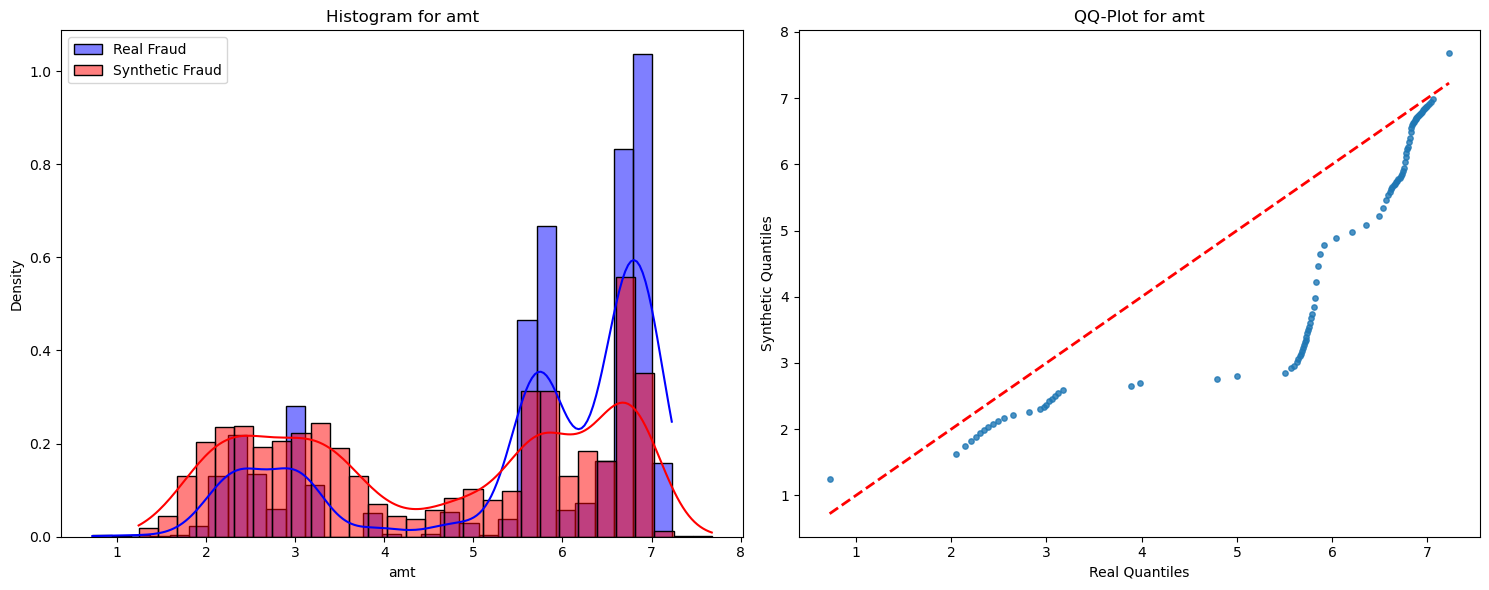

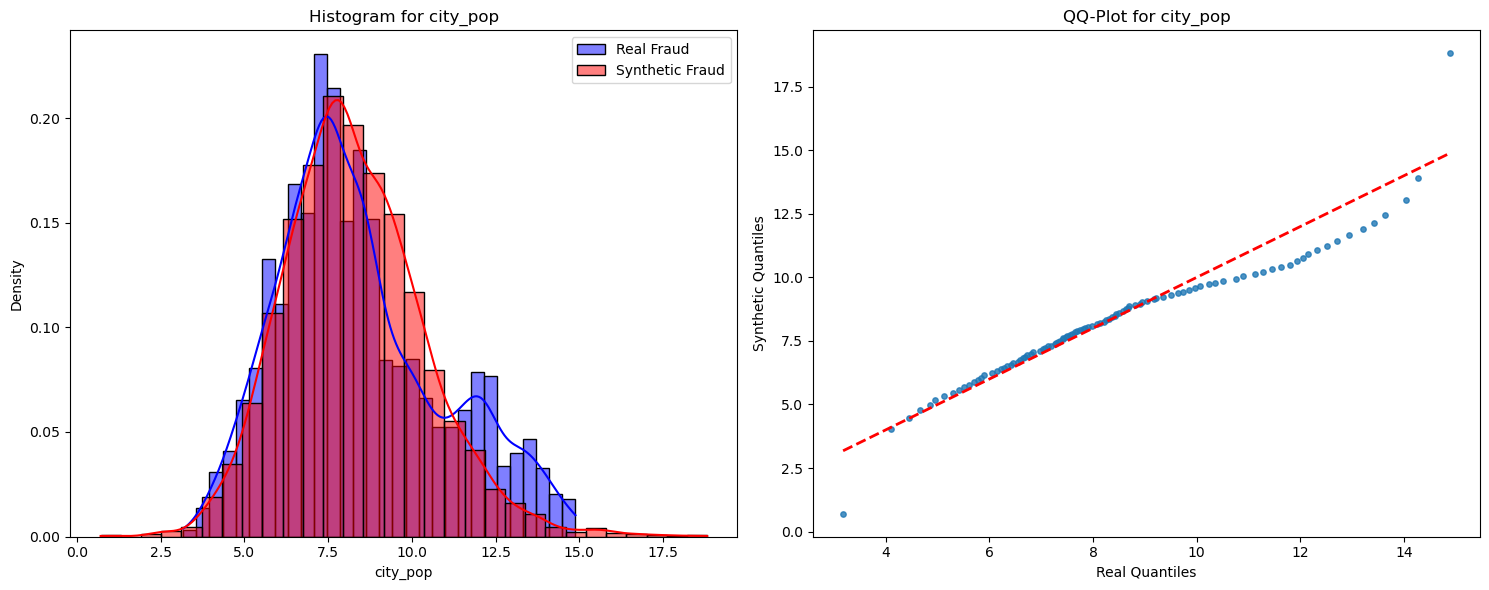

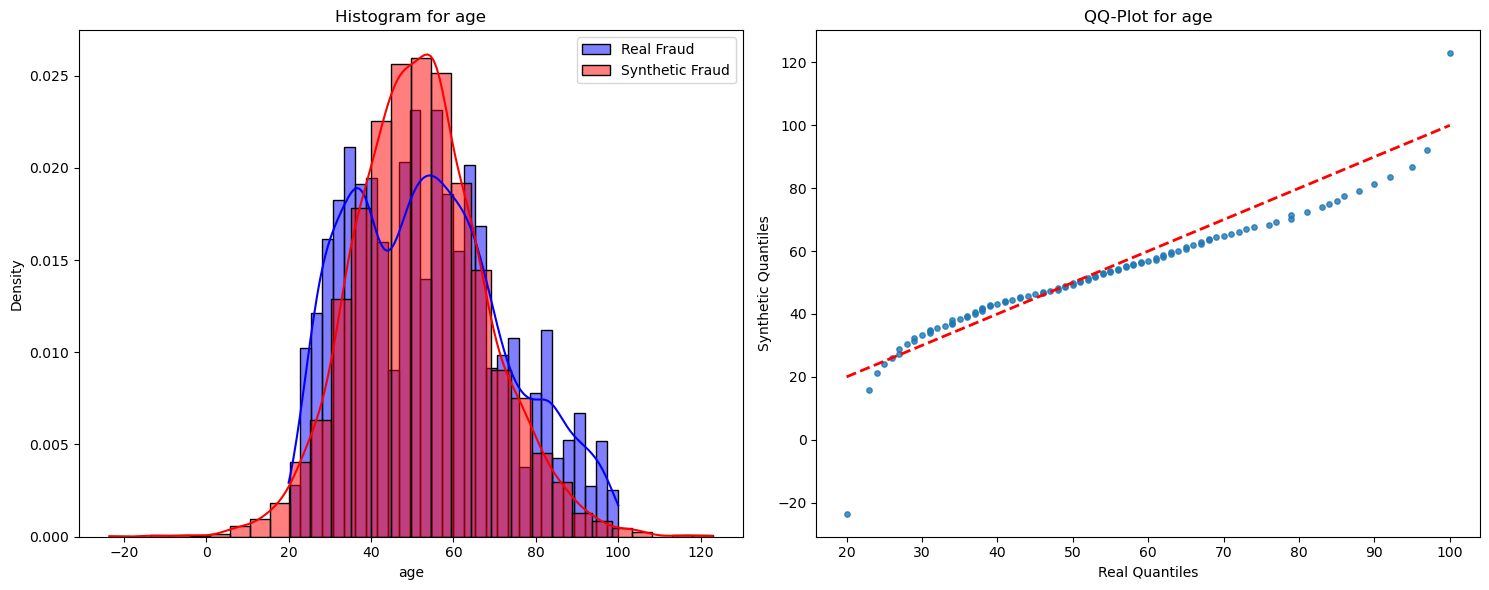

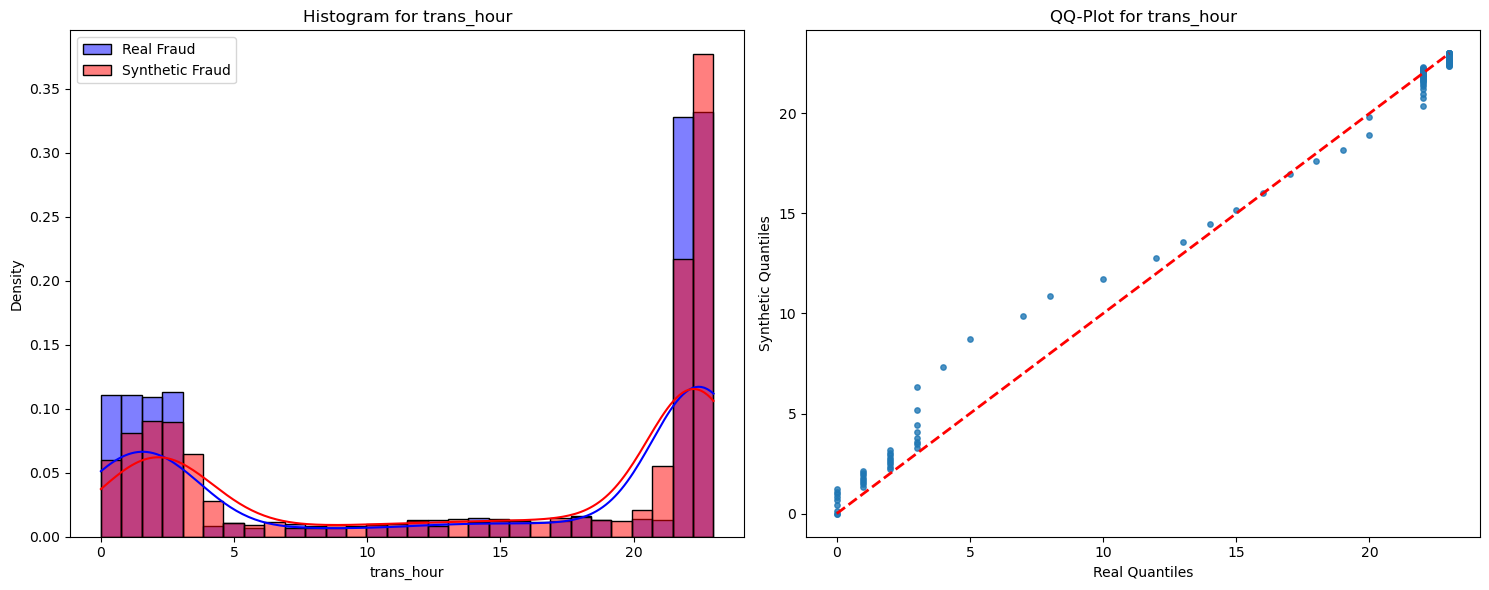

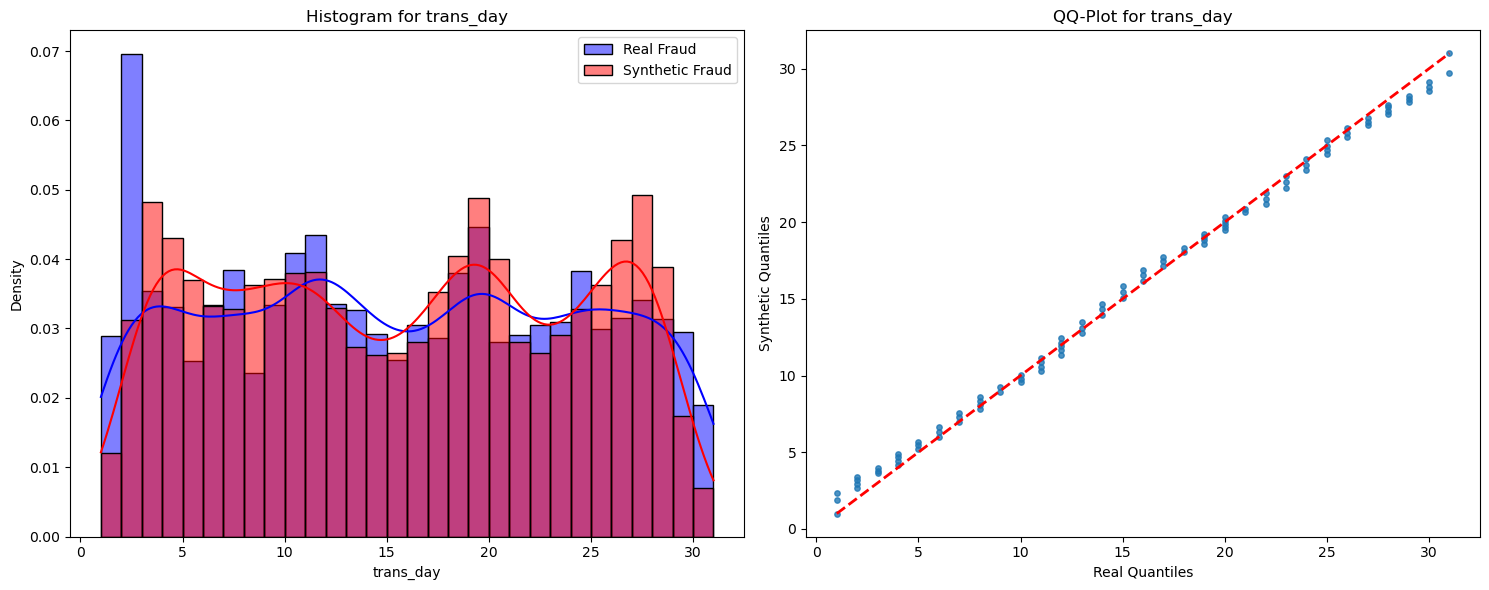

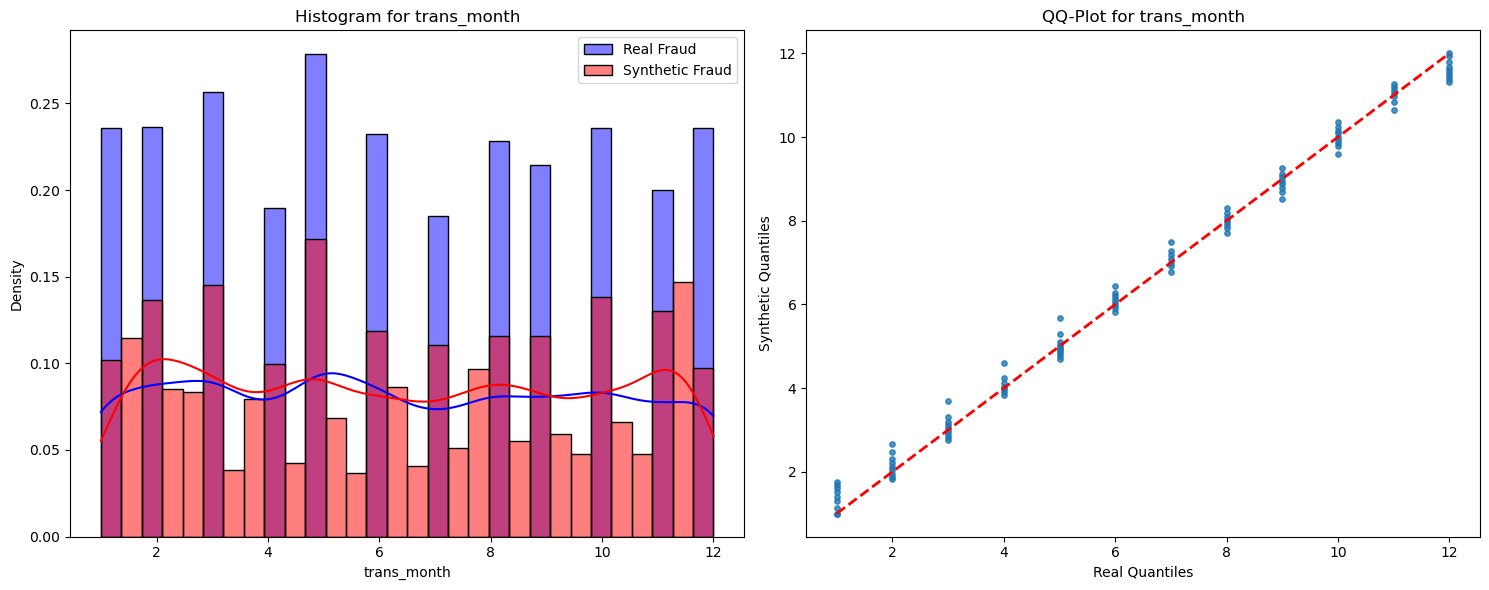

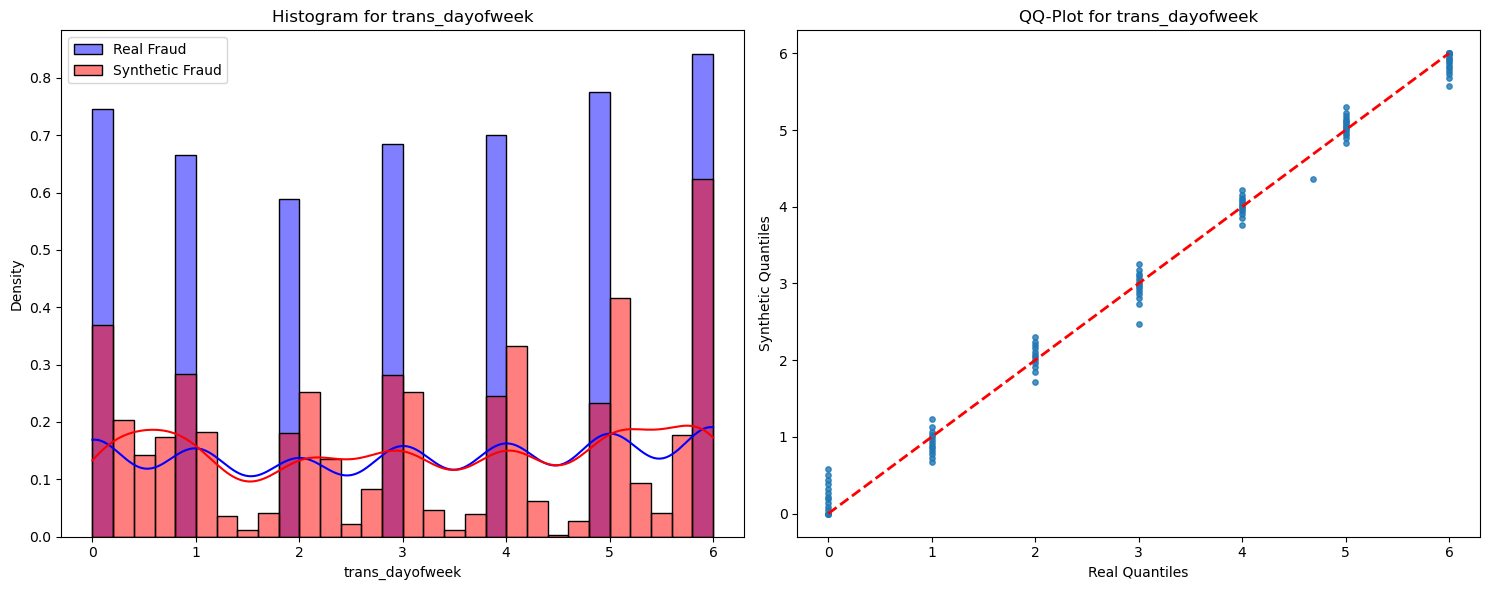

In [2]:
# Generate more synthetic samples
num_synthetic = 5000  # Increased from 100
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

#############################################
# Step 8: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

#############################################
# Step 9: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

# CHANGE: Create better visualizations including QQ plots
for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plt.figure(figsize=(15, 6))
    
    # Histogram comparison
    plt.subplot(1, 2, 1)
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    
    # QQ plot
    plt.subplot(1, 2, 2)
    from scipy import stats
    
    # Get real and synthetic data for this feature
    real_data = real_numeric_df[col].values
    syn_data = synthetic_numeric_df[col].values
    
    # Compute the quantiles using scipy
    quantiles_real = np.percentile(real_data, np.linspace(0, 100, 100))
    quantiles_syn = np.percentile(syn_data, np.linspace(0, 100, 100))
    
    # Plot the QQ plot
    plt.scatter(quantiles_real, quantiles_syn, alpha=0.8, s=15)
    plt.plot([min(quantiles_real), max(quantiles_real)], 
             [min(quantiles_real), max(quantiles_real)], 
             'r--', linewidth=2)
    
    plt.title(f"QQ-Plot for {col}")
    plt.xlabel("Real Quantiles")
    plt.ylabel("Synthetic Quantiles")
    
    plt.tight_layout()
    plt.show()


In [3]:
import numpy as np
import pandas as pd
from scipy import stats

def enhanced_statistical_comparison(real_numeric_df, synthetic_numeric_df, numeric_features):
    """
    For each numeric feature, this function computes:
      - Kolmogorov–Smirnov (KS) test statistic and p-value.
      - Anderson–Darling (AD) test statistic and significance level.
      - Skewness and kurtosis for both real and synthetic data.
      
    Parameters:
      real_numeric_df (pd.DataFrame): DataFrame containing real numeric data.
      synthetic_numeric_df (pd.DataFrame): DataFrame containing synthetic numeric data.
      numeric_features (list): List of feature names to compare.
      
    The function prints the statistics for each feature.
    """
    print("Enhanced Statistical Comparison")
    print("=" * 60)
    
    for col in numeric_features:
        # Extract data and remove missing values
        real_data = real_numeric_df[col].dropna().values
        syn_data = synthetic_numeric_df[col].dropna().values
        
        # Kolmogorov–Smirnov test
        ks_stat, ks_p = stats.ks_2samp(real_data, syn_data)
        
        # Anderson–Darling Test (two-sample)
        # anderson_ksamp may throw an exception if both distributions are identical,
        # so we safely wrap it in a try/except block.
        try:
            ad_result = stats.anderson_ksamp([real_data, syn_data])
            ad_stat = ad_result.statistic
            ad_sig = ad_result.significance_level
        except Exception as e:
            ad_stat = np.nan
            ad_sig = np.nan
            print(f"Error in Anderson–Darling test for {col}: {e}")

        # Compute skewness and kurtosis (Fisher's definition, normal distribution => 0 kurtosis)
        real_skew = stats.skew(real_data)
        syn_skew = stats.skew(syn_data)
        real_kurt = stats.kurtosis(real_data)
        syn_kurt = stats.kurtosis(syn_data)
        
        # Display the results
        print(f"\nFeature: {col}")
        print("-" * 60)
        print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
        print(f"Anderson–Darling Statistic: {ad_stat:.4f}, significance level: {ad_sig:.4f}")
        print(f"Real Skewness: {real_skew:.4f}, Synthetic Skewness: {syn_skew:.4f}")
        print(f"Real Kurtosis: {real_kurt:.4f}, Synthetic Kurtosis: {syn_kurt:.4f}")
        print("-" * 60)

# Define your list of numeric feature names.
numeric_features = ['amt', 'city_pop', 'merch_lat', 'merch_long', 
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']


if __name__ == "__main__":

    enhanced_statistical_comparison(real_numeric_df, synthetic_numeric_df, numeric_features)

Enhanced Statistical Comparison

Feature: amt
------------------------------------------------------------
KS Statistic: 0.3117, p-value: 0.0000
Anderson–Darling Statistic: 639.6930, significance level: 0.0010
Real Skewness: -1.0827, Synthetic Skewness: -0.0993
Real Kurtosis: -0.3416, Synthetic Kurtosis: -1.5512
------------------------------------------------------------

Feature: city_pop
------------------------------------------------------------
KS Statistic: 0.0881, p-value: 0.0000
Anderson–Darling Statistic: 41.7316, significance level: 0.0010
Real Skewness: 0.5893, Synthetic Skewness: 0.5261
Real Kurtosis: -0.2915, Synthetic Kurtosis: 0.9315
------------------------------------------------------------

Feature: merch_lat
------------------------------------------------------------
KS Statistic: 0.0365, p-value: 0.0012
Anderson–Darling Statistic: 9.5587, significance level: 0.0010
Real Skewness: 0.0380, Synthetic Skewness: 0.1064
Real Kurtosis: 1.7684, Synthetic Kurtosis: 1.2397

C:\Users\raghu\AppData\Local\Temp\ipykernel_96460\835363777.py:34: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])



Feature: merch_long
------------------------------------------------------------
KS Statistic: 0.1055, p-value: 0.0000
Anderson–Darling Statistic: 44.6768, significance level: 0.0010
Real Skewness: -1.2078, Synthetic Skewness: -0.7683
Real Kurtosis: 1.9799, Synthetic Kurtosis: 0.2511
------------------------------------------------------------

Feature: age
------------------------------------------------------------
KS Statistic: 0.0871, p-value: 0.0000
Anderson–Darling Statistic: 70.8768, significance level: 0.0010
Real Skewness: 0.3774, Synthetic Skewness: 0.2008
Real Kurtosis: -0.6331, Synthetic Kurtosis: 0.5633
------------------------------------------------------------

Feature: trans_hour
------------------------------------------------------------
KS Statistic: 0.1641, p-value: 0.0000
Anderson–Darling Statistic: 197.4645, significance level: 0.0010
Real Skewness: -0.4016, Synthetic Skewness: -0.4447
Real Kurtosis: -1.6987, Synthetic Kurtosis: -1.6229
-------------------------